# Quantum Mechanics Calculation using DVR

In [1]:
import math

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from discvar import Exponential, Sine

## Define model potential

Double well & cyclic boundary potential
$$
V(Q, \theta) = -aQ^2 + b Q^4 + \frac{W}{2}\left(1-\cos\theta\right)
$$

In [2]:
def potential(Q: np.ndarray, θ: np.ndarray) -> np.ndarray:
    W = 1.0
    a = 1.0e-03
    b = 1.0e-07
    return W / 2 * (1 - np.cos(θ)) + (-a * (Q**2) + b * (Q**4)) * 0.1

In [3]:
Q, θ = np.meshgrid(
    np.linspace(-150, 150, 100), np.linspace(-math.pi, math.pi, 100)
)

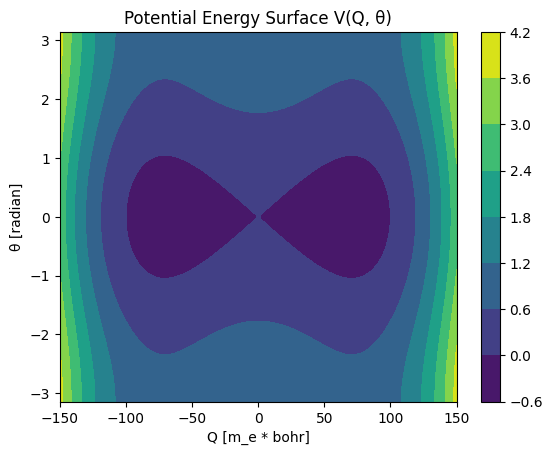

In [4]:
plt.title("Potential Energy Surface V(Q, θ)")
plt.contourf(Q, θ, potential(Q, θ))
plt.colorbar()
plt.xlabel("Q [m_e * bohr]")
plt.ylabel("θ [radian]")
plt.show()

## Define DVR basis

In [5]:
# basis_Q = Sine(ngrid=2**5, length=200.0, x0=-75.0, units="a.u.")
basis_Q = Sine(ngrid=2**7, length=300.0, x0=-150.0, units="a.u.")
basis_θ = Exponential(ngrid=2**5 - 1, length=2 * np.pi, x0=-np.pi)

grids = np.meshgrid(basis_Q.get_grids(), basis_θ.get_grids())

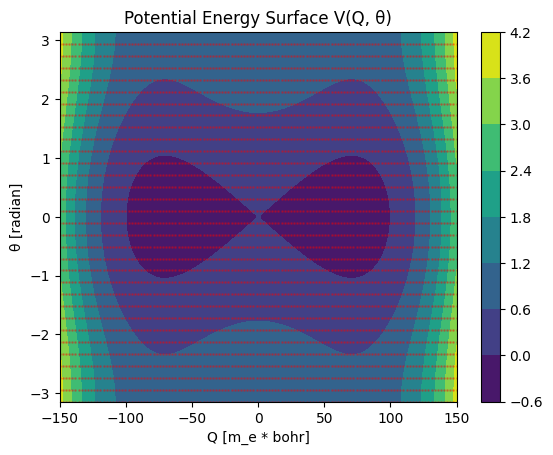

In [6]:
plt.title("Potential Energy Surface V(Q, θ)")
Q, θ = np.meshgrid(
    np.linspace(-150, 150, 100), np.linspace(-math.pi, math.pi, 100)
)
plt.contourf(Q, θ, potential(Q, θ))
plt.colorbar()
plt.scatter(*grids, s=1.0, alpha=0.3, c="red")
plt.xlabel("Q [m_e * bohr]")
plt.ylabel("θ [radian]")
plt.show()

## Define State Vector

$$
|\Psi\rangle = |Q\rangle \otimes |\theta \rangle
$$

In [7]:
class Psi:
    def __init__(self, basis0, basis1):
        self.basis0 = basis0
        self.basis1 = basis1
        self.grids = np.meshgrid(basis0.get_grids(), basis1.get_grids())
        self.coef = np.exp(
            1.0j
            * np.random.uniform(
                0, 2 * np.pi, (self.basis0.ngrid, self.basis1.ngrid)
            )
        )
        self.coef /= self.norm

    @property
    def norm(self):
        return np.sqrt(
            np.dot(
                self.coef.conjugate().reshape(-1), self.coef.reshape(-1)
            ).real
        )

    def plot_density(self):
        density = (self.coef.conjugate() * self.coef).real.reshape(
            self.basis0.ngrid, self.basis1.ngrid
        )
        plt.title("log|Ψ|^2")
        plt.contourf(
            self.grids[0], self.grids[1], np.log10(density.transpose())
        )
        plt.colorbar()
        plt.show()

    def plot_coef(self):
        real = self.coef.real.reshape(self.basis0.ngrid, self.basis1.ngrid)
        imag = self.coef.imag.reshape(self.basis0.ngrid, self.basis1.ngrid)
        plt.subplot(211)
        plt.title("Re(Ψ)")
        plt.contourf(self.grids[0], self.grids[1], real.transpose())
        plt.colorbar()
        plt.subplot(212)
        plt.title("Im(Ψ)")
        plt.contourf(self.grids[0], self.grids[1], imag.transpose())
        plt.colorbar()
        plt.tight_layout()
        plt.show()

In [8]:
Ψ = Psi(basis_Q, basis_θ)

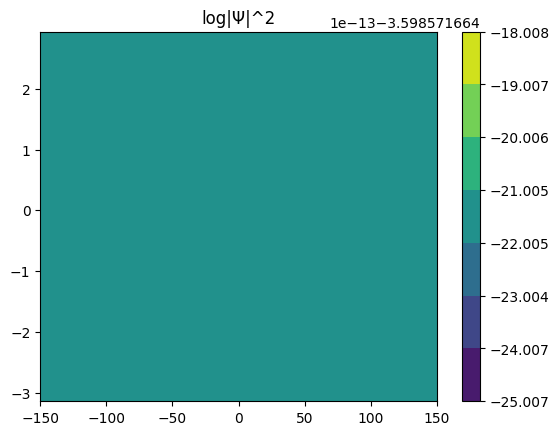

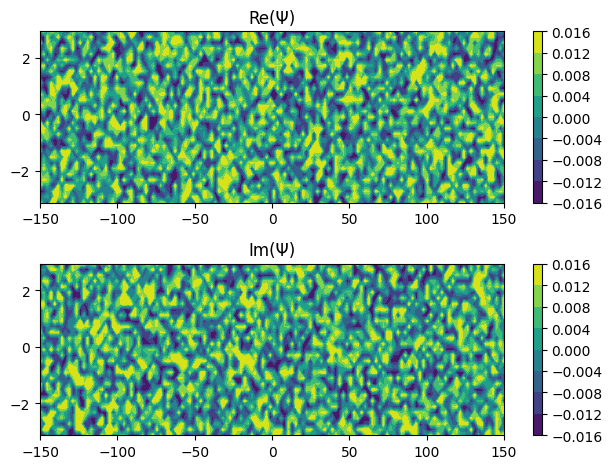

In [9]:
Ψ.plot_density()
Ψ.plot_coef()

## Define Hamiltonian

$$
\hat{H} = \hat{T} + \hat{V}
$$

In [10]:
T = np.zeros((basis_Q.ngrid, basis_θ.ngrid, basis_Q.ngrid, basis_θ.ngrid))
delta = np.eye(basis_θ.ngrid, basis_θ.ngrid)
T += np.einsum(
    "ij,kl->ikjl", -1.0 / 2.0 * basis_Q.get_2nd_derivative_matrix_dvr(), delta
)
delta = np.eye(basis_Q.ngrid, basis_Q.ngrid)
inertia = 1.0e02
T += np.einsum(
    "ij,kl->ikjl",
    delta,
    -1.0 / 2.0 / inertia * basis_θ.get_2nd_derivative_matrix_dvr(),
)

In [11]:
def nd_grid(*arrays):
    """

    Parameters:
    arrays : list of 1d array

    Returns:
    grid :
    """
    grids = np.meshgrid(*arrays, indexing="ij")
    return np.stack(grids, axis=-1).reshape(-1, len(arrays))

In [12]:
grids = nd_grid(basis_Q.get_grids(), basis_θ.get_grids())
V = potential(grids[:, 0], grids[:, 1])
delta = np.eye(
    basis_Q.ngrid * basis_θ.ngrid, basis_Q.ngrid * basis_θ.ngrid
).reshape(basis_Q.ngrid, basis_θ.ngrid, basis_Q.ngrid, basis_θ.ngrid)
V = np.einsum("ij,ijkl->ijkl", V.reshape(basis_Q.ngrid, basis_θ.ngrid), delta)
V.shape

(128, 31, 128, 31)

In [13]:
H = T + V
H = H.reshape(basis_Q.ngrid * basis_θ.ngrid, basis_Q.ngrid * basis_θ.ngrid)

## Solve Schrodinger Equation

In [14]:
np.testing.assert_allclose(H, H.conj().transpose())  # Check Hermitian

In [15]:
eigval, eigvec = np.linalg.eigh(H)

CPU times: user 7.82 s, sys: 99.6 ms, total: 7.92 s
Wall time: 7.88 s


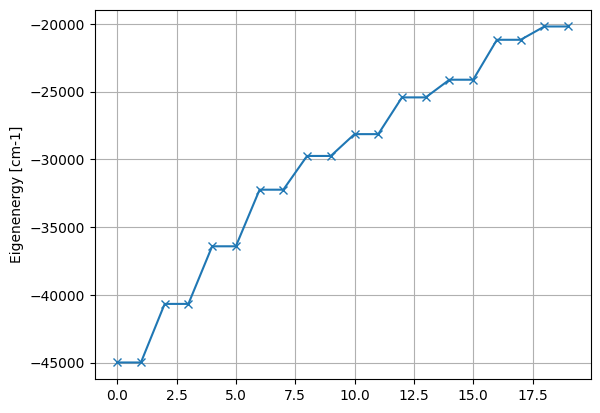

In [16]:
plt.plot((eigval[:20]) * 2.194746e5, marker="x")
plt.ylabel("Eigenenergy [cm-1]")
plt.grid()
plt.show()

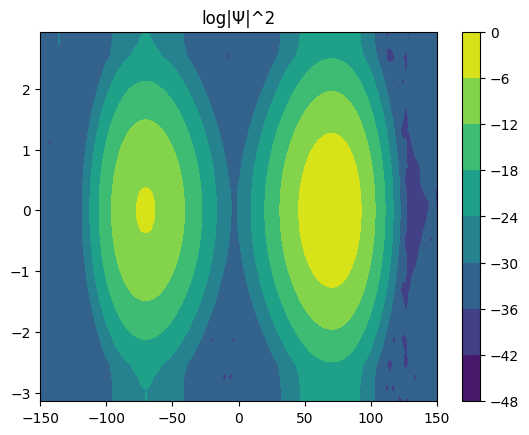

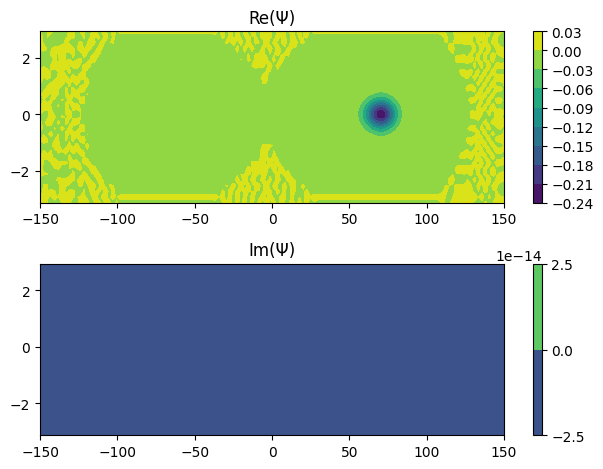

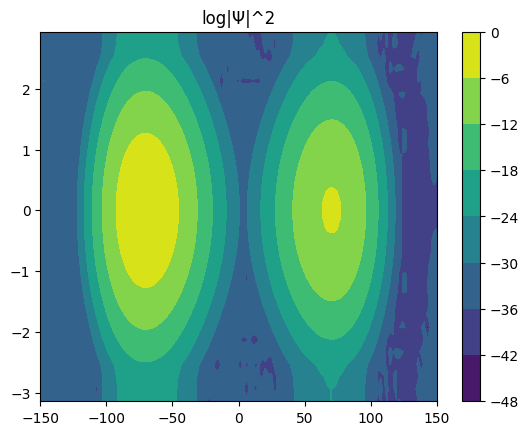

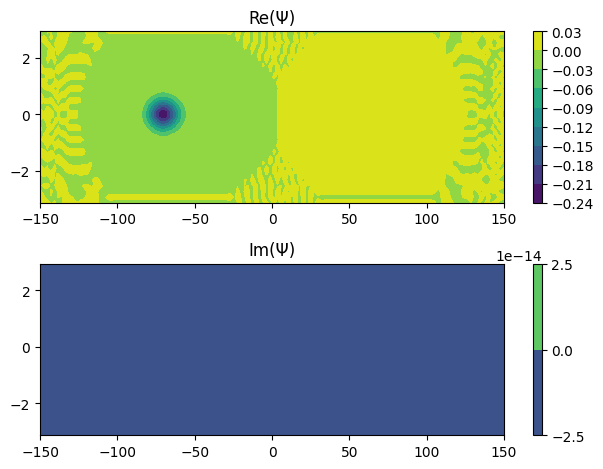

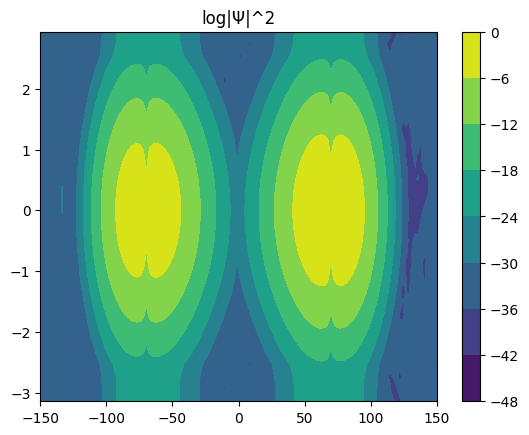

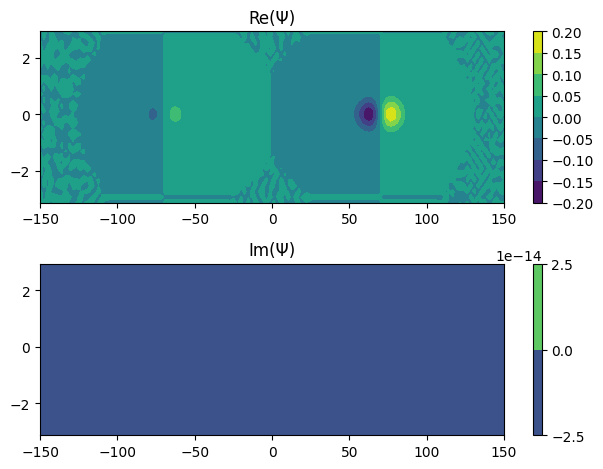

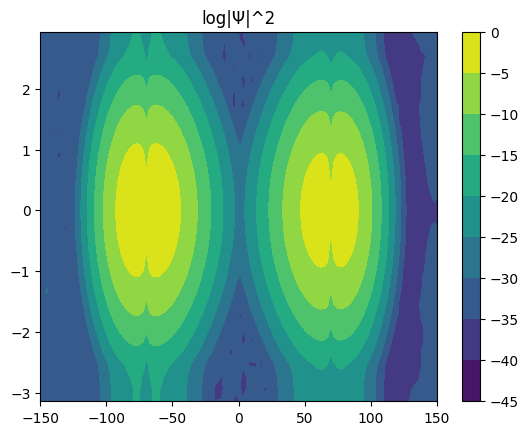

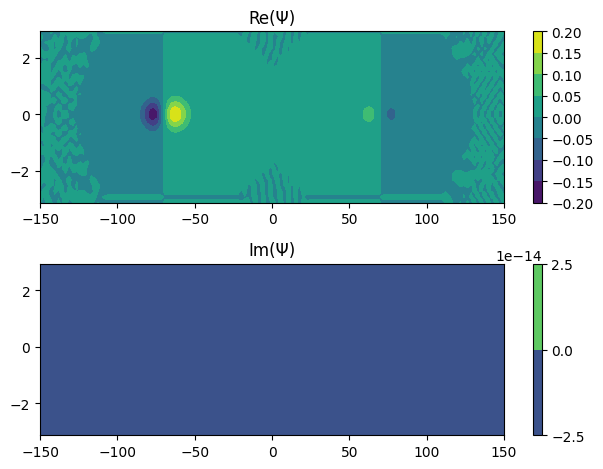

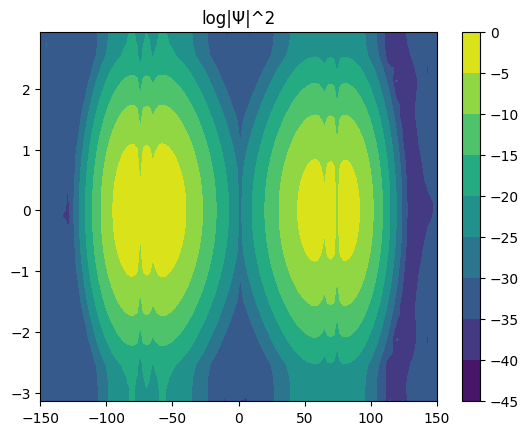

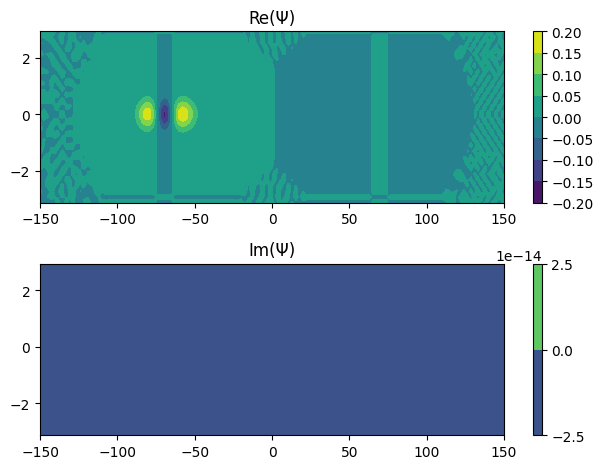

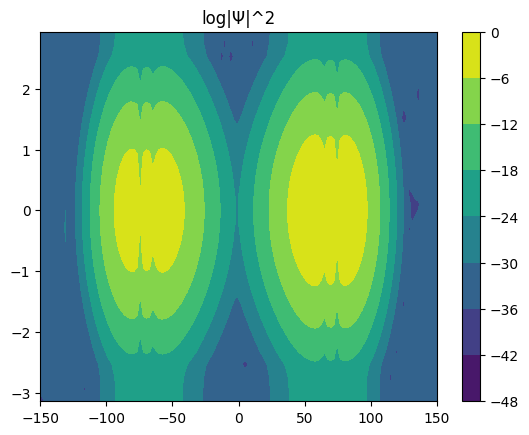

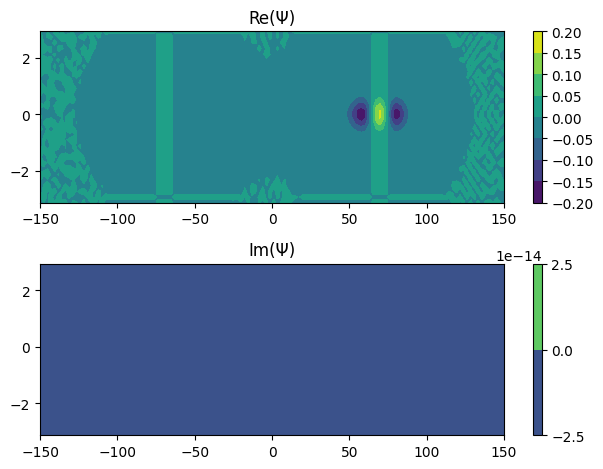

In [17]:
for i in range(6):
    Ψ.coef = eigvec[:, i]
    Ψ.plot_density()
    Ψ.plot_coef()

## Time evolution

Propagater is given by

$$
U(\Delta t) = \exp\left(\frac{\hat{H}}{i\hbar}\Delta t\right) \simeq \sum_{n=0}^{k} \frac{1}{n!} \left(\frac{\hat{H}\Delta t}{i\hbar}\right)^n
= \sum_i |i\rangle \sum_{n=0}^{k} \frac{1}{n!} \left(\frac{E_i\Delta t}{i\hbar}\right)^n \langle i|
$$

Wavefunction is propagated by
$$
\Psi(t+\Delta t) =U(\Delta t)\Psi(t)
$$

In [18]:
Δt = 100.0 / 41.341374575751
hbar = 1.0
# %time U = expm(-1.0j * Δt / hbar * H)
U = eigvec @ np.diag(np.exp(eigval / 1.0j / hbar * Δt)) @ eigvec.conj().T
U

array([[-1.67967993e-01+5.98381257e-01j, -4.35660319e-01-2.21151853e-02j,
         1.16617836e-01-1.45240720e-01j, ...,
        -3.25134414e-09+3.94687095e-09j,  1.05502673e-08-5.57806332e-09j,
        -2.50606251e-08-1.23737803e-08j],
       [-4.35660319e-01-2.21151853e-02j, -1.82761815e-01+5.94136468e-01j,
        -4.33974261e-01-4.35626221e-02j, ...,
         1.27832711e-09-2.24166059e-09j, -3.06566373e-09+4.10202870e-09j,
         1.04145652e-08-5.83661492e-09j],
       [ 1.16617836e-01-1.45240720e-01j, -4.33974261e-01-4.35626221e-02j,
        -2.25876732e-01+5.79434570e-01j, ...,
        -6.97687719e-10+1.33902991e-09j,  1.22865829e-09-2.27285834e-09j,
        -3.06566235e-09+4.10202852e-09j],
       ...,
       [-3.25134416e-09+3.94687094e-09j,  1.27832711e-09-2.24166058e-09j,
        -6.97687721e-10+1.33902992e-09j, ...,
        -2.93182433e-01+5.48970318e-01j, -4.27624085e-01-8.51965755e-02j,
         1.26679614e-01-1.36282898e-01j],
       [ 1.05502673e-08-5.57806332e-09j, -3.

Define initial wavepacket.

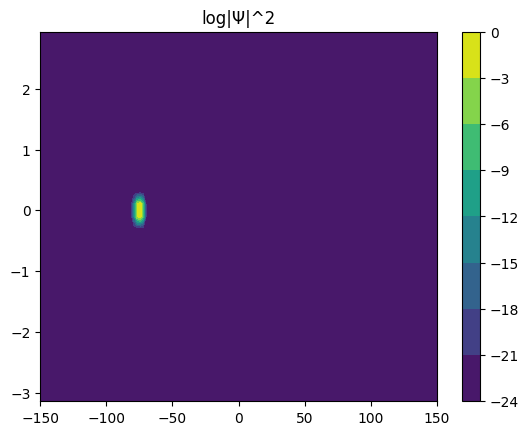

In [19]:
grids = nd_grid(basis_Q.get_grids(), basis_θ.get_grids())
Ψ.coef = (
    np.exp(-1.0 * (grids[:, 0] + 75) ** 2 - 1000 * (grids[:, 1]) ** 2) + 1.0e-16
)
Ψ.coef /= Ψ.norm
Ψ.plot_density()

MovieWriter ffmpeg unavailable; using Pillow instead.


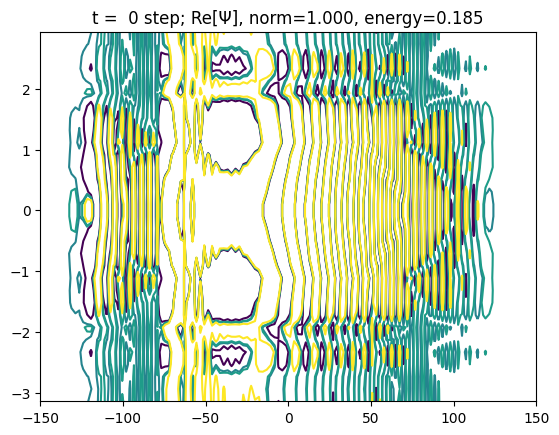

In [20]:
def update(i, Ψ):
    Ψ.coef = Ψ.coef @ U
    real = Ψ.coef.real.reshape(Ψ.basis0.ngrid, Ψ.basis1.ngrid)
    energy = (Ψ.coef.conjugate().reshape(1, -1) @ H @ Ψ.coef).real[0]
    plt.cla()
    plt.title(f"t = {i: d} step; Re[Ψ], norm={Ψ.norm:.3f}, energy={energy:.3f}")
    plt.contour(
        Ψ.grids[0],
        Ψ.grids[1],
        real.transpose(),
        levels=[-1.0e-03, -1.0e-04, 1.0e-04, 1.0e-03],
    )


fig = plt.figure()
ani = animation.FuncAnimation(fig, update, fargs=(Ψ,), interval=1, frames=50)
ani.save("wavepacket.gif")

We can see tunneling effect

![](wavepacket.gif)